<a href="https://colab.research.google.com/github/dangtbthi/gan_mnist/blob/main/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

In [2]:
%pip install torchinfo -q
from torchinfo import summary

# GAN Model

GAN model consists two multilayer-perceptron (MLP) neural networks: the discriminator ($D$) and the generator ($G$).

$D$ and $G$ play the following two-player minimax game with value function $V (G, D)$:
$$
\min_G \max_D V(D, G) =
\mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x)]
+ \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))].
$$

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
          super().__init__()
          self.in_features = in_features

          self.model = nn.Sequential(
              nn.Linear(in_features, 128),
              nn.LeakyReLU(0.1),
              nn.Linear(128, 1),
              nn.Sigmoid()
          )

    def forward(self, x):
          return self.model(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_dim = img_dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.21MB/s]


In [6]:
batch_size = 32
img_dim = 28*28
latent_dim = 64
lr = 3e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
num_epochs = 50
loss_fn = nn.BCELoss()

In [8]:
disc = Discriminator(img_dim).to(device)
gen = Generator(latent_dim, img_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

In [9]:
for epoch in tqdm(range(num_epochs)):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        # Train discriminator: max log(D(x)) + log(1-D(G(z)))
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = loss_fn(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        disc_opt.step()

        # Train generator
        output = disc(fake).view(-1)
        lossG = loss_fn(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        gen_opt.step()


100%|██████████| 50/50 [16:39<00:00, 19.98s/it]


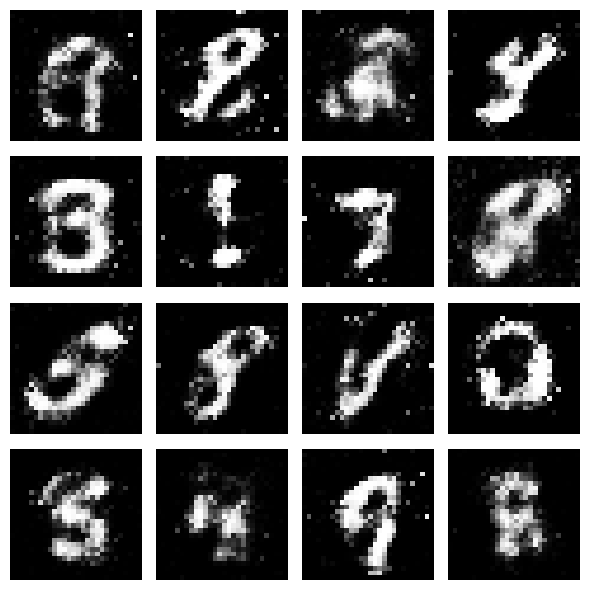

In [10]:
gen.eval()
num_samples = 16
noise = torch.randn(num_samples, latent_dim).to(device)
with torch.no_grad():
    fake_images = gen(noise).reshape(-1, 1, 28, 28).cpu()

# Hiển thị ảnh
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()